In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import copy
import socket
import os
import sys
import pandas as pd
import scipy.io as sio
import matplotlib
import scipy.signal as sg
from scipy.io import wavfile
import math
import scipy as sp
import pylab
import h5py
import pickle
import seaborn as sns
import random
import collections
import logging
import datetime
import itertools
import tensorflow as tf
import tensorflow.keras as keras
import sklearn
import gc
import importlib
import librosa
import librosa.display
from glob import glob
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [2]:
from math_utils import *

# location of wavs

In [3]:
data_folder = os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli/wavs')

In [4]:
all_wavs = sorted(glob(os.path.join(data_folder, '*.wav')))

In [5]:
print(all_wavs[0])

/mnt/cube/kai/repositories/morphs/data/stimuli/wavs/ac001.wav


In [6]:
wav = '/mnt/cube/kai/repositories/morphs/data/stimuli/wavs/ad061.wav'

y, sr = librosa.load(wav, sr=None)

In [7]:
sr

48000

In [8]:
spec_pars = {'fft_size': 2048, 
             'step_size': 256,
             'fmin': 850,
             'fmax': 10000}

In [9]:
spec_pars['n_mels'] = int(np.round(hz2star(spec_pars['fmax'])-hz2star(spec_pars['fmin'])))

In [11]:
print(f"Total star bands: {spec_pars['n_mels']}")

Total star bands: 186


# Compare normal spec vs mel vs star

(1025, 76)


[Text(0.5, 1.0, '/mnt/cube/kai/repositories/morphs/data/stimuli/wavs/ad061.wav')]

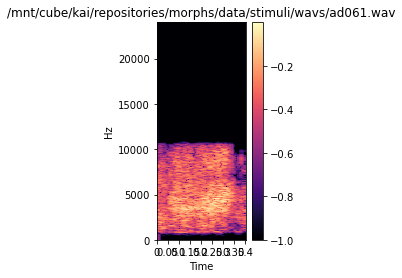

In [12]:
S_full = np.abs(librosa.stft(y, n_fft=spec_pars['fft_size'], hop_length=spec_pars['step_size'], 
                             win_length=spec_pars['fft_size'], window='hann')) ** 2
S_norm = librosa.util.normalize(librosa.power_to_db(S_full, ref=np.max))
    
print(S_norm.shape)
fig, ax = plt.subplots(figsize=(2, 4))
img = librosa.display.specshow(S_norm, x_axis='time', y_axis = 'hz', hop_length=spec_pars['step_size'], 
                         sr=sr, ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title=wav)

/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


[Text(0.5, 1.0, '/mnt/cube/kai/repositories/morphs/data/stimuli/wavs/ad061.wav')]

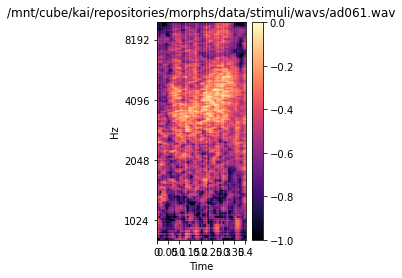

In [13]:
S_mel = librosa.feature.melspectrogram(y=y, 
                                       sr=sr, 
                                       n_mels=spec_pars['n_mels'], 
                                       n_fft=spec_pars['fft_size'], 
                                       fmin=spec_pars['fmin'],
                                       fmax=spec_pars['fmax'], 
                                       hop_length=spec_pars['step_size'], 
                                       win_length=spec_pars['fft_size'], 
                                       window='hann')
S_mel = librosa.util.normalize(librosa.power_to_db(S_mel, ref=np.max))

fig, ax = plt.subplots(figsize=(2, 4))
img = librosa.display.specshow(S_mel, 
                               x_axis='time', 
                               y_axis = 'mel',
                               sr=sr,
                               hop_length=spec_pars['step_size'], 
                               ax=ax, 
                               fmin=spec_pars['fmin'], 
                               fmax=spec_pars['fmax'],
                              )
fig.colorbar(img, ax=ax)
ax.set(title=wav)

[Text(0.5, 1.0, '/mnt/cube/kai/repositories/morphs/data/stimuli/wavs/ad061.wav')]

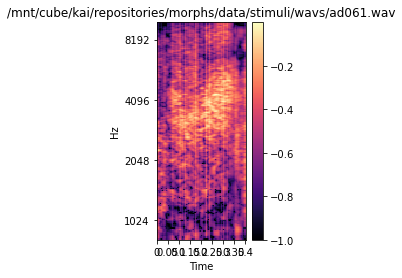

In [14]:
S_star = star_spectrogram(y=y, 
                          sr=sr, 
                          n_stars=spec_pars['n_mels'], 
                          n_fft=spec_pars['fft_size'], 
                          fmin=spec_pars['fmin'],
                          fmax=spec_pars['fmax'], 
                          hop_length=spec_pars['step_size'], 
                          win_length=spec_pars['fft_size'], 
                          window='hann')
S_star = librosa.util.normalize(librosa.power_to_db(S_star, ref=np.max))

fig, ax = plt.subplots(figsize=(2, 4))
img = librosa.display.specshow(S_star, x_axis='time', 
                               y_axis = 'mel',
                               sr=sr, 
                               ax=ax, 
                               hop_length=spec_pars['step_size'], 
                               fmin=spec_pars['fmin'], 
                               fmax=spec_pars['fmax'],)
fig.colorbar(img, ax=ax)
ax.set(title=wav)

In [17]:
S_mel.shape

(186, 76)

In [18]:
debug=False

# compile all

In [19]:
spec_file = os.path.join(os.path.abspath('/mnt/cube/kai/repositories/morphs/data/stimuli/'), 'spec_mel_restricted.p')
if os.path.exists(spec_file):
    paragraph_print(f'Skipping', separation = '>')
else:
    all_specs = list()
    all_cats = list()
    all_indeces = list()
    all_names = list()
    for wav in all_wavs:
        wav_name=wav.split('/')[-1].split('.')[0]
        cat = wav_name[:2]
        index = int(wav_name[2:])
        y, sr = librosa.load(wav, sr=None)
        S_mel =  librosa.feature.melspectrogram(y=y, 
                                       sr=sr, 
                                       n_mels=spec_pars['n_mels'], 
                                       n_fft=spec_pars['fft_size'], 
                                       fmin=spec_pars['fmin'],
                                       fmax=spec_pars['fmax'], 
                                       hop_length=spec_pars['step_size'], 
                                       win_length=spec_pars['fft_size'], 
                                       window='hann')
        S_norm = librosa.util.normalize(librosa.power_to_db(S_mel, ref=np.max))
        assert S_norm.shape[1]==76
        if debug:
            print(S_norm.shape)
            fig, ax = plt.subplots(figsize=(12, 4))
            img = librosa.display.specshow(S_norm, x_axis='time', y_axis = 'mel',
                                     sr=sr, ax=ax)
            fig.colorbar(img, ax=ax)
            ax.set(title=wav)
            break
        all_specs.append(S_norm)
        all_cats.append(cat)
        all_indeces.append(index)
        all_names.append(wav)
    morph_df = pd.DataFrame()
    morph_df['stim'] = all_cats
    morph_df['id'] = all_indeces
    morph_df['wav'] = all_names
    morph_df['spec'] = all_specs

In [20]:
morph_df.head()

,stim,id,wav,spec
0,ac,1,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23444802, -0.32770982, -0.4576597, -0.440..."
1,ac,2,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.19216497, -0.3240278, -0.4519775, -0.4527..."
2,ac,3,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.22530042, -0.2954273, -0.45014453, -0.464..."
3,ac,4,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.23662604, -0.3088082, -0.45463002, -0.488..."
4,ac,5,/mnt/cube/kai/repositories/morphs/data/stimuli...,"[[-0.27267733, -0.33855087, -0.4580862, -0.497..."


In [21]:
morph_df.to_pickle(spec_file)
del morph_df